<a href="https://colab.research.google.com/github/TivoGatto/Thesis/blob/master/RAE/L2_RAE_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# LIBRARIES
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, Dense, Flatten, Reshape, Conv2DTranspose, Lambda
from keras.datasets import cifar10
from keras.regularizers import l2
import keras.backend as K

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
# Parameters
input_dim = (32, 32, 3)
latent_dim = 128

epochs = 150
batch_size = 100

initial_lr = 1e-4
halve_at_epoch_1 = 80
halve_at_epoch_2 = 120

lamb = 1e-6
beta = 1e-3

TRAIN = False

In [ ]:
# Functions
def rae_loss(z):
    def loss(x_true, x_pred):
        x_true = K.reshape(x_true, (-1, np.prod(input_dim)))
        x_pred = K.reshape(x_pred, (-1, np.prod(input_dim)))

        L_rec = 0.5 * K.sum(K.square(x_true - x_pred), axis=-1)
        L_rae = 0.5 * K.sum(K.square(z), axis=-1)

        return K.mean(L_rec + beta * L_rae)
    return loss

def recon(x_true, x_pred):
    x_true = K.reshape(x_true, (-1, np.prod(input_dim)))
    x_pred = K.reshape(x_pred, (-1, np.prod(input_dim)))

    return K.mean(0.5 * K.sum(K.square(x_true - x_pred), axis=-1))

def RAE(z):
    def rae(x_true, x_pred):
        return K.mean(0.5 * K.sum(K.square(z), axis=-1))
    return rae

In [ ]:
# Dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')/255
x_test  = x_test.astype('float32')/255

print('x_train shape: ' + str(x_train.shape))
print('x_test shape: ' + str(x_test.shape))

170500096/170498071 [==============================] - 11s 0us/step
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)


In [ ]:
# Model Architecture
# ENCODER
x = Input(shape=input_dim) # Shape (32, 32, 3)

h = Conv2D(64, 4, strides=(2, 2), padding='same')(x) # Shape (16, 16, 64)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2D(128, 4, strides=(2, 2), padding='same')(h) # Shape (8, 8, 128)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2D(256, 4, strides=(2, 2), padding='same')(h) # Shape (4, 4, 256)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2D(512, 4, strides=(2, 2), padding='same')(h) # Shape (2, 2, 512)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Flatten()(h)

z = Dense(latent_dim)(h)

encoder = Model(x, z)

# DECODER
z_in = Input(shape=(latent_dim, ))

h = Dense(4 * 4 * 512, kernel_regularizer=l2(lamb))(z_in)
h = Reshape((4, 4, 512))(h)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2DTranspose(256, 4, strides=(2, 2), padding='same', kernel_regularizer=l2(lamb))(h) # Shape (4, 4, 256)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2DTranspose(128, 4, strides=(2, 2), padding='same', kernel_regularizer=l2(lamb))(h) # Shape (8, 8, 128)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2DTranspose(64, 4, strides=(2, 2), padding='same', kernel_regularizer=l2(lamb))(h) # Shape (16, 16, 64)
h = BatchNormalization()(h)
h = ReLU()(h)

x_decoded = Conv2DTranspose(3, 4, strides=(1, 1), padding='same', activation='sigmoid', kernel_regularizer=l2(lamb))(h)

decoder = Model(z_in, x_decoded)

# VAE
x_recon = decoder(z)

vae = Model(x, x_recon)

# Compile the model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
steps_per_epoch = 45000 / batch_size
lr_schedule = PiecewiseConstantDecay([steps_per_epoch * halve_at_epoch_1, steps_per_epoch * halve_at_epoch_2], 
                                     [initial_lr, initial_lr/2, initial_lr/4])
optimizer = Adam(learning_rate=lr_schedule)

vae.compile(optimizer=optimizer, loss=rae_loss(z), metrics=[recon, RAE(z)])

In [ ]:
if TRAIN:
    # Fit model
    hist = vae.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

# Save training history

In [ ]:
if TRAIN:
    loss = hist.history['loss']
    recon = hist.history['recon']
    kl = hist.history['rae']

    val_loss = hist.history['val_loss']
    val_recon = hist.history['val_recon']
    val_kl = hist.history['val_rae']

    from numpy import savetxt
    # save history
    data = np.asarray([loss, recon, kl, val_loss, val_recon, val_kl])
    savetxt('L2_RAE_CIFAR10.csv', data, delimiter=',')

    # Save model
    vae.save_weights('L2-RAE_CIFAR10.h5')
else:
    vae.load_weights('L2-RAE_CIFAR10.h5')

In [ ]:
# Learn latent space distribution
z_train = encoder.predict(x_train)

prior_for_qz = "GMM" # Choose between GMM or Gaussian
if prior_for_qz == "GMM":
    from sklearn.mixture import GaussianMixture

    z_density = GaussianMixture(n_components=10, max_iter=100)
    z_density.fit(z_train)

    print("Learned GMM")
elif prior_for_qz == "Gaussian":
    from scipy.stats import norm

    mean, std = norm.fit(z_train) # z_train is fitted to a gaussian N(mean, std)
    print("Learned Gaussian")
else:
    print("Distribution not found")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Learned GMM


# Generation and Reconstruction

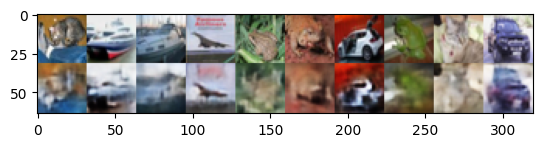

In [ ]:
# Reconstruction
n = 10
digit_size = input_dim[0]

x_recon = vae.predict(x_test, batch_size=batch_size)
figure = np.zeros((2 * digit_size, n * digit_size, 3))
for i in range(n):
    figure[:digit_size, i * digit_size: (i+1) * digit_size, :] = x_test[i]
    figure[digit_size:, i * digit_size: (i+1) * digit_size, :] = x_recon[i]

plt.style.use('default')
plt.imshow(figure)
plt.savefig('L2-RAE_CIFAR10_reconstruction.png')
plt.show()

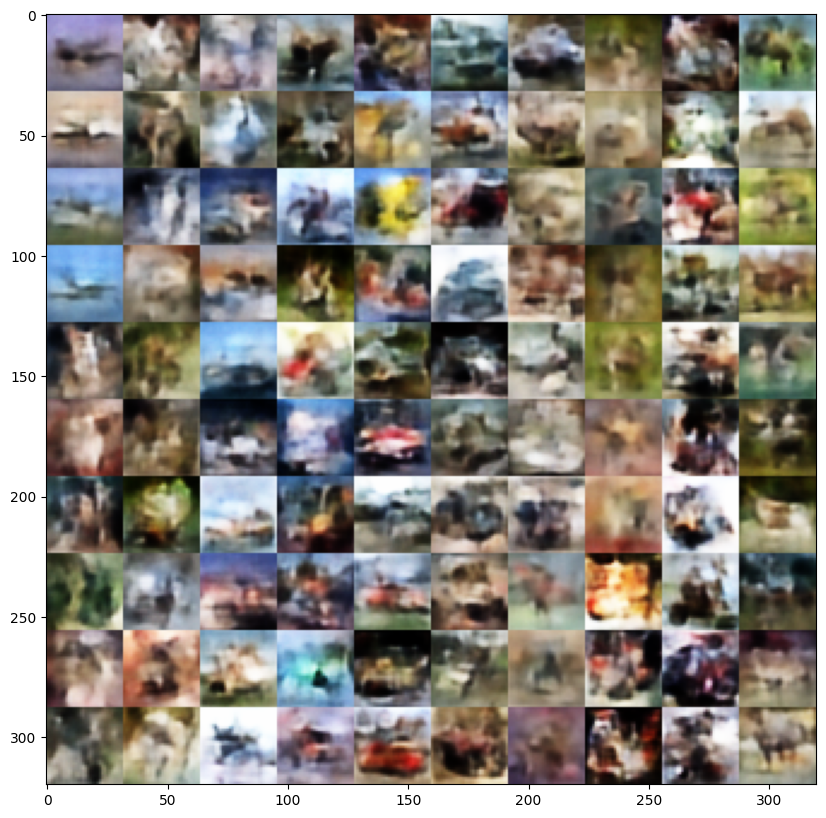

In [ ]:
# Generation
n = 10 #figure with n x n digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n, 3))
# we will sample n points randomly sampled

if prior_for_qz == "GMM":
    z_sample = z_density.sample(n**2)
    z_sample = z_sample[0]
elif prior_for_qz == "Gaussian":
    z_sample = np.random.normal(size=(n**2, latent_dim), loc=mean, scale=std)
else:
    print("Distribution not found")

for i in range(n):
    for j in range(n):
        x_decoded = decoder.predict(np.array([z_sample[i + n * j]]))
        figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = x_decoded

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.savefig('L2-RAE_CIFAR10_generation.png')
plt.show()

# Interpolation

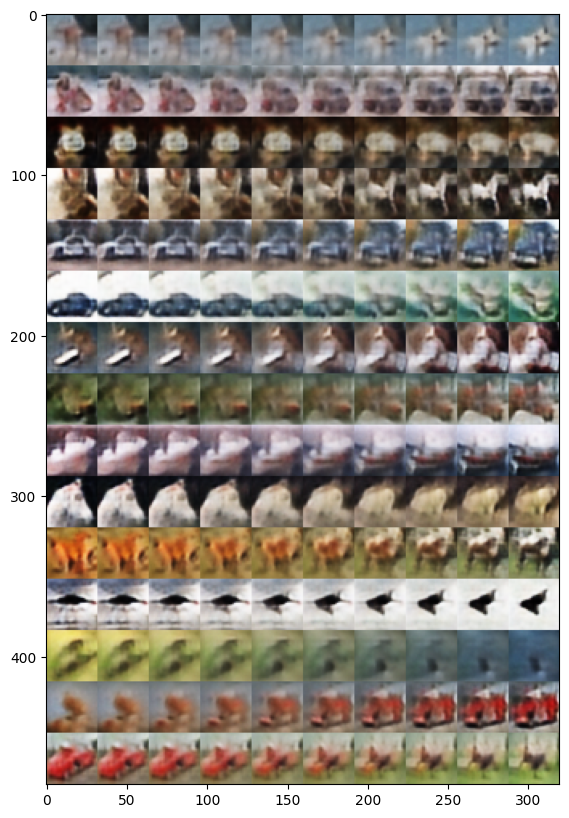

In [ ]:
T = 10
N = 15

s = 10
k = 100

X_final = [0] * N
for n in range(N):
    x_a = x_test[n + s]
    x_b = x_test[n + k]

    z_a = encoder.predict(np.reshape(x_a, (1, 32, 32, 3)))
    z_b = encoder.predict(np.reshape(x_b, (1, 32, 32, 3)))


    X = [0] * T
    for i in range(T):
        t = i/T
        z = t * z_a + (1 - t) * z_b

        X[i] = decoder.predict(z)
    
    X_final[n] = X

digit_size = 32
figure = np.zeros((N * digit_size, T * digit_size, 3))
for n in range(N):
    for i in range(T):
        figure[n * digit_size : (n+1) * digit_size, i * digit_size : (i+1) * digit_size, :] = X_final[n][i][0, :, :, :]

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.savefig('L2-RAE_CIFAR10_interpolation.png')
plt.show()

# Nearest Neighbour

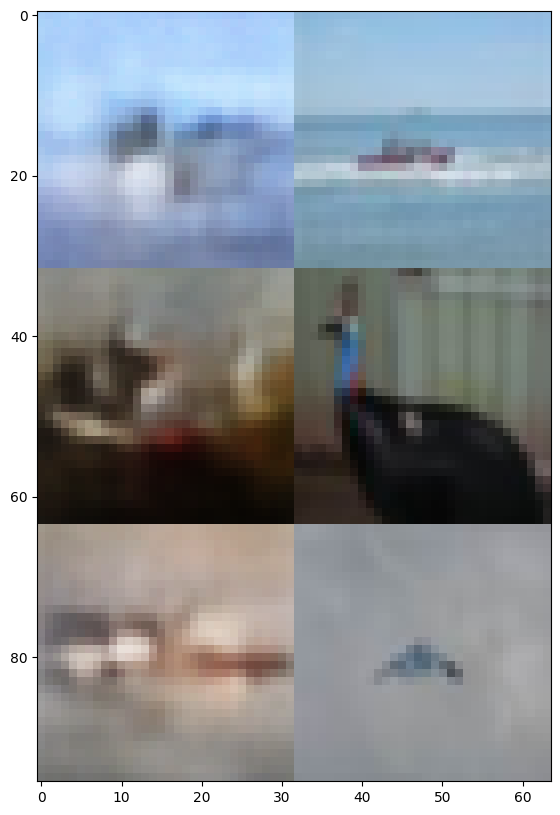

In [ ]:
# We want to investigate overfitting
def get_distance(x, y_vec):
    digit_size = x.shape[0]
    x = np.reshape(x, (digit_size**2*3, ))
    y_vec = np.reshape(y_vec, (-1, digit_size**2*3, ))

    res = np.zeros((y_vec.shape[0], ))
    for j in range(y_vec.shape[0]):
        res[j] = np.mean(np.square(x - y_vec[j]))

    return res

N = 3 # Images we need to check
digit_size = 32

if prior_for_qz == "GMM":
    z = z_density.sample(n**2)
elif prior_for_qz == "Gaussian":
    z = np.random.normal(size=(n**2, latent_dim), loc=mean, scale=std)
else:
    print("Distribution not found")

x_gen = decoder.predict(z)
figure = np.zeros((N * digit_size, 2 * digit_size, 3))
for i in range(N):
    x = x_gen[i]
    distances = get_distance(x, x_train)
    m = np.min(distances)
    i_m = np.argmin(distances)

    figure[i * digit_size : (i+1) * digit_size, : digit_size, :] = x
    figure[i * digit_size : (i+1) * digit_size, digit_size :] = x_train[i_m]

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.savefig('L2_RAE_CIFAR10_NN.png')
plt.show()

# Metrics Evaluation

In [ ]:
import numpy as np
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
#from keras.applications.inception_v3 import preprocess_input
#from skimage.transform import resize
#from tensorflow.keras.models import load_model
#import os
#from matplotlib import pyplot

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3), weights='imagenet')

def get_inception_activations(inps, batch_size=100):
    n_batches = inps.shape[0]//batch_size
    act = np.zeros([inps.shape[0], 2048], dtype = np.float32)
    for i in range(n_batches):
        inp = inps[i * batch_size:(i + 1) * batch_size]
        inpr = tf.image.resize(inp, (299, 299))
        act[i * batch_size:(i + 1) * batch_size] = model.predict(inpr,steps=1)
        
        print('Processed ' + str((i+1) * batch_size) + ' images.')
    return act

def get_fid(images1, images2):
    print(images1.shape)
    print(images2.shape)
    print(type(images1))
    # calculate activations
    act1 = get_inception_activations(images1,batch_size=100)
    #print(np.shape(act1))
    act2 = get_inception_activations(images2,batch_size=100)
    # compute mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # compute sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

if prior_for_qz == "GMM":
    z_sample = z_density.sample(x_test.shape[0])
elif prior_for_qz == "Gaussian":
    z_sample = np.random.normal(size=(x_test.shape[0], latent_dim), loc=mean, scale=std)
else:
    print("Distribution not found")
x_gen = decoder.predict(z_sample)

fid = get_fid(x_test, x_gen)
print('\n FID: %.3f' % fid)

87916544/87910968 [==============================] - 3s 0us/step
(10000, 32, 32, 3)
(10000, 32, 32, 3)
<class 'numpy.ndarray'>
Processed 100 images.
Processed 200 images.
Processed 300 images.
Processed 400 images.
Processed 500 images.
Processed 600 images.
Processed 700 images.
Processed 800 images.
Processed 900 images.
Processed 1000 images.
Processed 1100 images.
Processed 1200 images.
Processed 1300 images.
Processed 1400 images.
Processed 1500 images.
Processed 1600 images.
Processed 1700 images.
Processed 1800 images.
Processed 1900 images.
Processed 2000 images.
Processed 2100 images.
Processed 2200 images.
Processed 2300 images.
Processed 2400 images.
Processed 2500 images.
Processed 2600 images.
Processed 2700 images.
Processed 2800 images.
Processed 2900 images.
Processed 3000 images.
Processed 3100 images.
Processed 3200 images.
Processed 3300 images.
Processed 3400 images.
Processed 3500 images.
Processed 3600 images.
Processed 3700 images.
Processed 3800 images.
Processe

In [ ]:
def loss_variance(x_true, x_recon):
    x_true = np.reshape(x_true, (-1, np.prod(x_true.shape[1:])))
    x_recon = np.reshape(x_recon, (-1, np.prod(x_recon.shape[1:])))

    var_true = np.mean(np.var(x_true, axis=1), axis=0)
    var_recon = np.mean(np.var(x_recon, axis=1), axis=0)

    return np.abs(var_true - var_recon)

########################################################################################################################
# SHOW THE RESULTS
########################################################################################################################

x_recon = vae.predict(x_train, batch_size=batch_size)
print('We lost ', loss_variance(x_test, x_recon), 'Variance of the original data')

In [ ]:
# Compute moments
n = len(x_test)

if prior_for_qz == "GMM":
	z_sample = z_density.sample(n)[0]
elif prior_for_qz == "Gaussian":
	z_sample = np.random.normal(size=(n, latent_dim), loc=mean, scale=std)
else:
	print("Distribution not found")

from scipy.stats import moment
# First moment matching:
z_first_moment = np.mean(np.mean(z_sample, axis=0))

print("\n")
print("First moment of q(z): " + str(z_first_moment))
print("\n")

# Second moment matching:
z_second_moment = np.mean(np.var(z_sample, axis=0))

print("\n")
print("Second moment of q(z): " + str(z_second_moment))
print("\n")

# Thid moment matching:
z_third_moment = np.mean(moment(z_sample, moment=3, axis=0))

print("\n")
print("Third moment of q(z): " + str(z_third_moment))
print("\n")